In [7]:
import xarray as xr #This is for working with netcdf (.nc) datas
import matplotlib.pyplot as plt #This is for plotting the data
import pandas as pd
import numpy as np

In [8]:
ds=xr.open_dataset('Temp_Data_1940_monthly.nc')

In [9]:
print(ds)

<xarray.Dataset>
Dimensions:     (valid_time: 899, latitude: 721, longitude: 1440)
Coordinates:
    number      int64 ...
  * valid_time  (valid_time) datetime64[ns] 1951-01-01 1951-02-01 ... 2025-11-01
  * latitude    (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    expver      (valid_time) object ...
Data variables:
    t2m         (valid_time, latitude, longitude) float32 ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-11-07T06:08 GRIB to CDM+CF via cfgrib-0.9.1...


In [10]:
temp = ds.t2m
temp_c = temp - 273.15



In [11]:
t2m_mean = temp_c.weighted(np.cos(np.deg2rad(temp.latitude))).mean(dim=["latitude", "longitude"])

In [12]:
baseline = t2m_mean.sel(valid_time=slice("1951-01-01", "1980-12-31"))
baseline_mean = baseline.mean()
anomaly = t2m_mean - baseline_mean


In [13]:
time = ds.valid_time

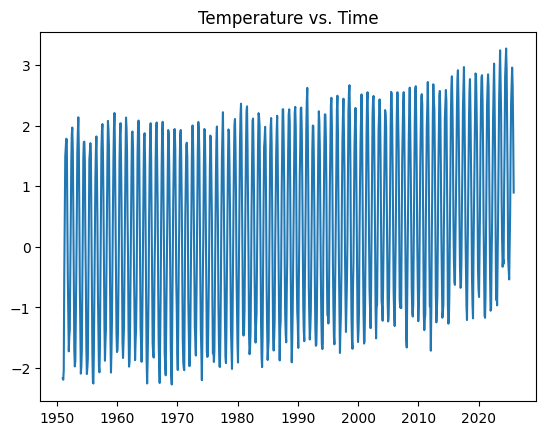

In [14]:
plt.plot(time,anomaly)
plt.title('Temperature vs. Time')
plt.show()


In [15]:
t2m_mean = t2m_mean.to_numpy()

In [16]:
time = time.to_numpy()

In [17]:
anomaly = anomaly.to_numpy()

In [18]:
Monthly_Temp_Data = pd.DataFrame({
    'Time': time,
    'Temperature': t2m_mean,
    'Anomaly': anomaly
})

In [19]:
Monthly_Temp_Data.to_csv('Temp_Data.csv', index=False)

In [20]:
temp = pd.read_csv('Temp_Data.csv')

In [21]:
co2 = pd.read_csv('co2_mm_mlo.csv')

In [22]:
ch4 = pd.read_csv('ch4_mm_gl.csv')

In [23]:
# --- Prepare temperature data ---
temp["Year"] = pd.to_datetime(temp["Time"]).dt.year
temp["Month"] = pd.to_datetime(temp["Time"]).dt.month

# --- Filter datasets for Jan 1984 – Dec 2024 ---
co2_filtered = co2[(co2["year"] >= 1984) & (co2["year"] <= 2024)]
ch4_filtered = ch4[(ch4["year"] >= 1984) & (ch4["year"] <= 2024)]
temp_filtered = temp[(temp["Year"] >= 1984) & (temp["Year"] <= 2024)]

# --- Select relevant columns ---
co2_filtered = co2_filtered[["year", "month", "average"]].rename(columns={"average": "CO2_conc"})
ch4_filtered = ch4_filtered[["year", "month", "average"]].rename(columns={"average": "CH4_conc"})
temp_filtered = temp_filtered[["Year", "Month", "Anomaly"]]

# --- Merge datasets ---
merged = pd.merge(co2_filtered, ch4_filtered, on=["year", "month"], how="inner")
merged = pd.merge(merged, temp_filtered, left_on=["year", "month"], right_on=["Year", "Month"], how="inner")

# --- Clean and finalize ---
merged.drop(columns=["Year", "Month"], inplace=True)
merged.rename(columns={"year": "Year", "month": "Month"}, inplace=True)

# Month Number starts from Jan 1984 = 1
merged["Month Number"] = (merged["Year"] - 1984) * 12 + merged["Month"]

# Reorder columns
merged = merged[["Year", "Month Number", "CO2_conc", "CH4_conc", "Anomaly"]]
merged.sort_values(by=["Year", "Month Number"], inplace=True)

In [24]:
merged

,Year,Month Number,CO2_conc,CH4_conc,Anomaly
0,1984,1,344.21,1638.73,-1.831463
1,1984,2,344.92,1638.81,-1.984625
2,1984,3,345.68,1640.86,-1.477274
3,1984,4,347.38,1643.97,-0.281835
4,1984,5,347.77,1643.14,0.751058
...,...,...,...,...,...
487,2024,488,422.99,1925.21,3.276253
488,2024,489,422.03,1934.81,2.921213
489,2024,490,422.38,1941.02,2.010962
490,2024,491,423.85,1940.01,1.039338


In [25]:
Month_Number = merged['Month Number']
CO2_conc = merged['CO2_conc']
CH4_conc = merged['CH4_conc']
Anomaly = merged['Anomaly']

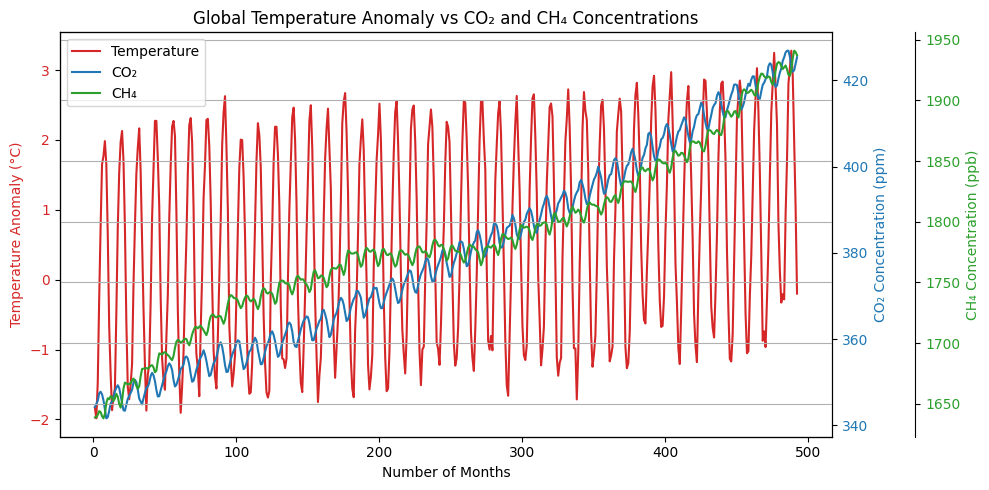

In [26]:
fig, ax1 = plt.subplots(figsize=(10, 5))

# --- Plot Temperature on the left y-axis ---
color1 = 'tab:red'
ax1.set_xlabel('Number of Months')
ax1.set_ylabel('Temperature Anomaly (°C)', color=color1)
ax1.plot(Month_Number, Anomaly, color=color1, label='Temperature')
ax1.tick_params(axis='y', labelcolor=color1)

# --- Create a second y-axis (for CO₂) ---
ax2 = ax1.twinx()
color2 = 'tab:blue'
ax2.set_ylabel('CO₂ Concentration (ppm)', color=color2)
ax2.plot(Month_Number, CO2_conc, color=color2, label='CO₂')
ax2.tick_params(axis='y', labelcolor=color2)

# --- Create a third y-axis (for CH₄) ---
ax3 = ax1.twinx()
color3 = 'tab:green'
ax3.spines["right"].set_position(("outward", 60))  # shift outward so it doesn’t overlap
ax3.set_ylabel('CH₄ Concentration (ppb)', color=color3)
ax3.plot(Month_Number, CH4_conc, color=color3, label='CH₄')
ax3.tick_params(axis='y', labelcolor=color3)

# --- Add title, grid, and combine legends ---
plt.title('Global Temperature Anomaly vs CO₂ and CH₄ Concentrations')
fig.tight_layout()
plt.grid(True)

# Combine legends from all axes
lines, labels = [], []
for ax in [ax1, ax2, ax3]:
    line, label = ax.get_legend_handles_labels()
    lines += line
    labels += label
plt.legend(lines, labels, loc='upper left')

plt.show()

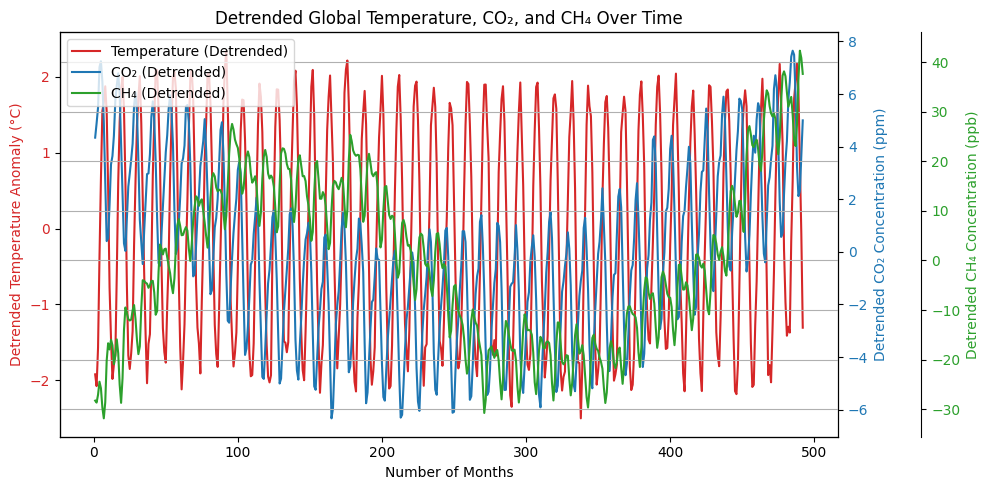

In [27]:
from scipy import signal

# --- Step 1: Convert to numpy arrays (just in case) ---
Anomaly = np.array(Anomaly)
CO2_conc = np.array(CO2_conc)
CH4_conc = np.array(CH4_conc)

# --- Step 2: Detrend each series ---
Anomaly_detrended = signal.detrend(Anomaly)
CO2_detrended = signal.detrend(CO2_conc)
CH4_detrended = signal.detrend(CH4_conc)

# --- Step 3: Plot detrended data ---
fig, ax1 = plt.subplots(figsize=(10, 5))

color1 = 'tab:red'
ax1.set_xlabel('Number of Months')
ax1.set_ylabel('Detrended Temperature Anomaly (°C)', color=color1)
ax1.plot(Month_Number, Anomaly_detrended, color=color1, label='Temperature (Detrended)')
ax1.tick_params(axis='y', labelcolor=color1)

# --- Second y-axis for CO₂ ---
ax2 = ax1.twinx()
color2 = 'tab:blue'
ax2.set_ylabel('Detrended CO₂ Concentration (ppm)', color=color2)
ax2.plot(Month_Number, CO2_detrended, color=color2, label='CO₂ (Detrended)')
ax2.tick_params(axis='y', labelcolor=color2)

# --- Third y-axis for CH₄ ---
ax3 = ax1.twinx()
color3 = 'tab:green'
ax3.spines["right"].set_position(("outward", 60))
ax3.set_ylabel('Detrended CH₄ Concentration (ppb)', color=color3)
ax3.plot(Month_Number, CH4_detrended, color=color3, label='CH₄ (Detrended)')
ax3.tick_params(axis='y', labelcolor=color3)

# --- Title and layout ---
plt.title('Detrended Global Temperature, CO₂, and CH₄ Over Time')
fig.tight_layout()
plt.grid(True)

# --- Combine legends from all three axes ---
lines, labels = [], []
for ax in [ax1, ax2, ax3]:
    line, label = ax.get_legend_handles_labels()
    lines += line
    labels += label
plt.legend(lines, labels, loc='upper left')

plt.show()

Peak correlation at lag = 39.0 months (r = 0.697, p = 2.9866e-67)


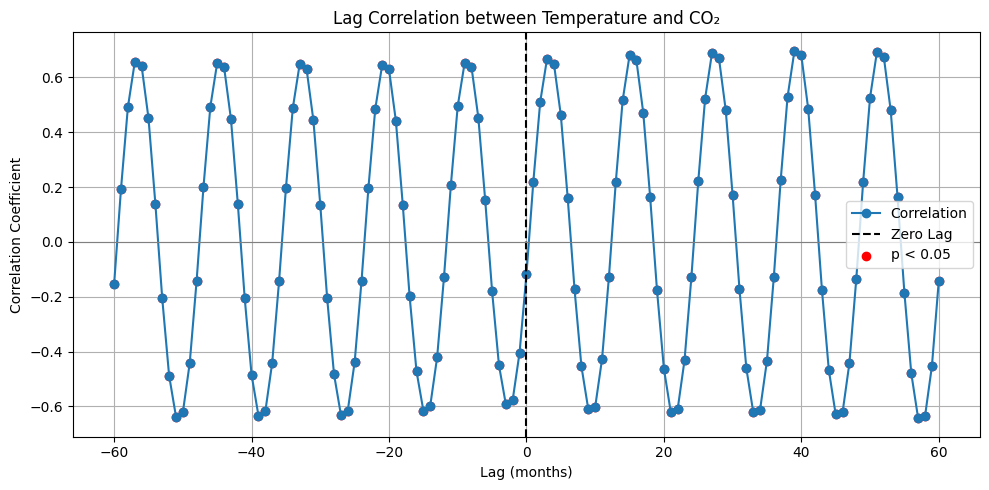

In [51]:
from scipy.stats import pearsonr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

temp = pd.Series(Anomaly_detrended)
co2  = pd.Series(CO2_detrended)

max_lag = 60  # in months
lags = range(-max_lag, max_lag + 1)

r_values = []
p_values = []

for lag in lags:
    # align data after shifting
    x = temp
    y = co2.shift(lag)
    valid = ~(x.isna() | y.isna())
    
    if valid.sum() > 2:  # at least 3 points to correlate
        r, p = pearsonr(x[valid], y[valid])
    else:
        r, p = np.nan, np.nan
    r_values.append(r)
    p_values.append(p)

corr_df = pd.DataFrame({'Lag (months)': lags, 'Correlation': r_values, 'p-value': p_values})

# Find the lag with maximum absolute correlation
best_lag = corr_df.loc[corr_df['Correlation'].abs().idxmax()]
print(f"Peak correlation at lag = {best_lag['Lag (months)']} months (r = {best_lag['Correlation']:.3f}, p = {best_lag['p-value']:.4e})")

# --- Plot correlation vs lag ---
plt.figure(figsize=(10,5))
plt.plot(corr_df['Lag (months)'], corr_df['Correlation'], marker='o', label='Correlation')
plt.axvline(0, color='k', linestyle='--', label='Zero Lag')
plt.axhline(0, color='grey', linewidth=0.8)
plt.title('Lag Correlation between Temperature and CO₂')
plt.xlabel('Lag (months)')
plt.ylabel('Correlation Coefficient')

# highlight statistically significant lags
sig_mask = corr_df['p-value'] < 0.05
plt.scatter(corr_df.loc[sig_mask, 'Lag (months)'],
            corr_df.loc[sig_mask, 'Correlation'],
            color='red', label='p < 0.05')

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [29]:
ch4 = pd.Series(CH4_detrended)

Peak correlation at lag = 31.0 months (r = 0.246, p = 8.4674e-08)


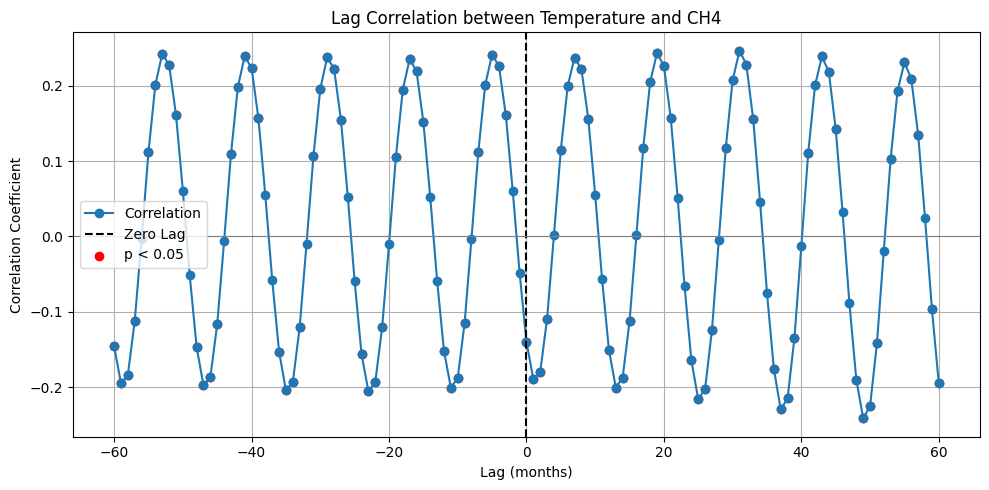

In [30]:
# max_lag = 15  #months
# lags = range(-max_lag, max_lag + 1)
# correlations = [temp.corr(ch4.shift(lag)) for lag in lags]

# corr_df = pd.DataFrame({'Lag (months)': lags, 'Correlation': correlations})

# plt.figure(figsize=(8,5))
# plt.plot(corr_df['Lag (months)'], corr_df['Correlation'], marker='o')
# plt.axvline(0, color='k', linestyle='--', label='Zero Lag')
# plt.title('Lag Correlation between Temperature and CH4')
# plt.xlabel('Lag (months)')
# plt.ylabel('Correlation Coefficient')
# plt.grid(True)
# plt.legend()
# plt.show()



max_lag = 60  # in months
lags = range(-max_lag, max_lag + 1)

r_values = []
p_values = []

for lag in lags:
    # align data after shifting
    x = temp
    y = ch4.shift(lag)
    valid = ~(x.isna() | y.isna())
    
    if valid.sum() > 2:  # at least 3 points to correlate
        r, p = pearsonr(x[valid], y[valid])
    else:
        r, p = np.nan, np.nan
    r_values.append(r)
    p_values.append(p)

corr_df = pd.DataFrame({'Lag (months)': lags, 'Correlation': r_values, 'p-value': p_values})

# Find the lag with maximum absolute correlation
best_lag = corr_df.loc[corr_df['Correlation'].abs().idxmax()]
print(f"Peak correlation at lag = {best_lag['Lag (months)']} months (r = {best_lag['Correlation']:.3f}, p = {best_lag['p-value']:.4e})")

# --- Plot correlation vs lag ---
plt.figure(figsize=(10,5))
plt.plot(corr_df['Lag (months)'], corr_df['Correlation'], marker='o', label='Correlation')
plt.axvline(0, color='k', linestyle='--', label='Zero Lag')
plt.axhline(0, color='grey', linewidth=0.8)
plt.title('Lag Correlation between Temperature and CH4')
plt.xlabel('Lag (months)')
plt.ylabel('Correlation Coefficient')

# highlight statistically significant lags
sig_mask = corr_df['p-value'] < 0.05
plt.scatter(corr_df.loc[sig_mask, 'Lag (months)'],
            corr_df.loc[sig_mask, 'Correlation'],
            color='red', label='p < 0.05')

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [52]:
from statsmodels.tsa.stattools import grangercausalitytests

data = pd.concat([temp, co2], axis=1)
data.columns = ['temperature', 'co2']

grangercausalitytests(data, maxlag=12)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=306.8914, p=0.0000  , df_denom=488, df_num=1
ssr based chi2 test:   chi2=308.7781, p=0.0000  , df=1
likelihood ratio test: chi2=239.5541, p=0.0000  , df=1
parameter F test:         F=306.8914, p=0.0000  , df_denom=488, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=17.3065 , p=0.0000  , df_denom=485, df_num=2
ssr based chi2 test:   chi2=34.9699 , p=0.0000  , df=2
likelihood ratio test: chi2=33.7784 , p=0.0000  , df=2
parameter F test:         F=17.3065 , p=0.0000  , df_denom=485, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=17.4563 , p=0.0000  , df_denom=482, df_num=3
ssr based chi2 test:   chi2=53.1295 , p=0.0000  , df=3
likelihood ratio test: chi2=50.4366 , p=0.0000  , df=3
parameter F test:         F=17.4563 , p=0.0000  , df_denom=482, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=19.9287 , p=0.0000  

{1: ({'ssr_ftest': (306.8914486604936, 1.1537143834343374e-53, 488.0, 1),
   'ssr_chi2test': (308.7780764186524, 4.0310128998963706e-69, 1),
   'lrtest': (239.55406704427457, 4.9197063638351125e-54, 1),
   'params_ftest': (306.89144866049395, 1.1537143834341732e-53, 488.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (17.30653800647353, 5.4948300939257266e-08, 485.0, 2),
   'ssr_chi2test': (34.969911848132085, 2.549060397976533e-08, 2),
   'lrtest': (33.77842394879076, 4.624964843624379e-08, 2),
   'params_ftest': (17.306538006474206, 5.494830093922076e-08, 485.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (17.456302122836366, 8.961941782895474e-11, 482.0, 3),
   'ssr_chi2test': (53.129450651869185, 1.7204782014653654e-11, 3),
   'lrtest': (50.436595599030625, 6.449313260650032e-11, 3),
   'params_ftest': (17.456302122836266, 8.961941782896842e-11, 482.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0.

In [ ]:
# from statsmodels.tsa.stattools import grangercausalitytests

# data = pd.concat([temp, ch4], axis=1)
# data.columns = ['temperature', 'ch4']

# grangercausalitytests(data, maxlag=12)

In [53]:
from statsmodels.tsa.stattools import grangercausalitytests

data = pd.concat([co2, temp], axis=1)
data.columns = ['co2', 'temperature']

grangercausalitytests(data, maxlag=12)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=682.6317, p=0.0000  , df_denom=488, df_num=1
ssr based chi2 test:   chi2=686.8282, p=0.0000  , df=1
likelihood ratio test: chi2=429.6169, p=0.0000  , df=1
parameter F test:         F=682.6317, p=0.0000  , df_denom=488, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=81.6793 , p=0.0000  , df_denom=485, df_num=2
ssr based chi2 test:   chi2=165.0427, p=0.0000  , df=2
likelihood ratio test: chi2=142.2446, p=0.0000  , df=2
parameter F test:         F=81.6793 , p=0.0000  , df_denom=485, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=97.6098 , p=0.0000  , df_denom=482, df_num=3
ssr based chi2 test:   chi2=297.0822, p=0.0000  , df=3
likelihood ratio test: chi2=232.1278, p=0.0000  , df=3
parameter F test:         F=97.6098 , p=0.0000  , df_denom=482, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=136.8186, p=0.0000  

{1: ({'ssr_ftest': (682.6317362347468, 8.992451942155184e-95, 488.0, 1),
   'ssr_chi2test': (686.8282428099603, 2.1879027860750394e-151, 1),
   'lrtest': (429.61686006467585, 1.969148649672446e-95, 1),
   'params_ftest': (682.6317362347469, 8.992451942155184e-95, 488.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (81.67930527224138, 2.6740253051509155e-31, 485.0, 2),
   'ssr_chi2test': (165.04271993153927, 1.4502027612713866e-36, 2),
   'lrtest': (142.24458119991255, 1.2941411659934095e-31, 2),
   'params_ftest': (81.6793052722413, 2.6740253051510293e-31, 485.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (97.60984332104506, 2.2385303522652167e-49, 482.0, 3),
   'ssr_chi2test': (297.0822409791973, 4.2583759314991885e-64, 3),
   'lrtest': (232.12777665743874, 4.794643863709934e-50, 3),
   'params_ftest': (97.60984332104532, 2.2385303522647396e-49, 482.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 

In [ ]:
# from statsmodels.tsa.stattools import ccf
# import matplotlib.pyplot as plt
# import numpy as np

# ccf_vals = ccf(Anomaly_detrended, CO2_detrended)
# lags = np.arange(len(ccf_vals))

# plt.plot(lags, ccf_vals)
# plt.axvline(0, color='k', linestyle='--')
# plt.title('Cross-Correlation: Temperature vs CO₂')
# plt.xlabel('Lag (months)')
# plt.ylabel('Correlation')
# plt.show()


Peak correlation at lag = 15.0 months (r = 0.600, p = 1.7843e-43)


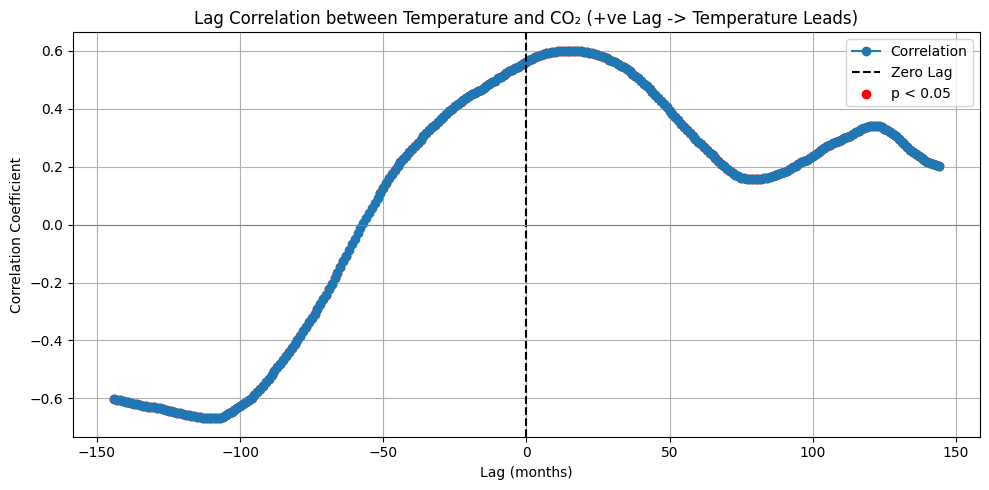

In [35]:
temp_smooth = temp.rolling(window=48, center=True).mean()
co2_smooth = co2.rolling(window=48, center=True).mean()

# temp_std = (temp_smooth - temp_smooth.mean()) / temp_smooth.std()
# co2_std = (co2_smooth - co2_smooth.mean()) / co2_smooth.std()

# max_lag = 50  # in months
# lags = range(-max_lag, max_lag + 1)
# correlations = [temp_smooth.corr(co2_smooth.shift(lag)) for lag in lags]

# corr_df = pd.DataFrame({'Lag (months)': lags, 'Correlation': correlations})

# plt.figure(figsize=(8,5))
# plt.plot(corr_df['Lag (months)'], corr_df['Correlation'], marker='o')
# plt.axvline(0, color='k', linestyle='--', label='Zero Lag')
# plt.title('Lag Correlation between Smoothened Temperature and CO₂')
# plt.xlabel('Lag (months)')
# plt.ylabel('Correlation Coefficient')
# plt.grid(True)
# plt.legend()
# plt.show()

max_lag = 144  # in months
lags = range(-max_lag, max_lag + 1)

r_values = []
p_values = []

for lag in lags:
    # align data after shifting
    x = temp_smooth
    y = co2_smooth.shift(lag)
    valid = ~(x.isna() | y.isna())
    
    if valid.sum() > 2:  # at least 3 points to correlate
        r, p = pearsonr(x[valid], y[valid])
    else:
        r, p = np.nan, np.nan
    r_values.append(r)
    p_values.append(p)

corr_df = pd.DataFrame({'Lag (months)': lags, 'Correlation': r_values, 'p-value': p_values})

# Find the lag with maximum absolute correlation
best_lag = corr_df.loc[corr_df['Correlation'].idxmax()]
print(f"Peak correlation at lag = {best_lag['Lag (months)']} months (r = {best_lag['Correlation']:.3f}, p = {best_lag['p-value']:.4e})")

# --- Plot correlation vs lag ---
plt.figure(figsize=(10,5))
plt.plot(corr_df['Lag (months)'], corr_df['Correlation'], marker='o', label='Correlation')
plt.axvline(0, color='k', linestyle='--', label='Zero Lag')
plt.axhline(0, color='grey', linewidth=0.8)
plt.title('Lag Correlation between Temperature and CO₂ (+ve Lag -> Temperature Leads)')
plt.xlabel('Lag (months)')
plt.ylabel('Correlation Coefficient')

# highlight statistically significant lags
sig_mask = corr_df['p-value'] < 0.05
plt.scatter(corr_df.loc[sig_mask, 'Lag (months)'],
            corr_df.loc[sig_mask, 'Correlation'],
            color='red', label='p < 0.05')

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Peak correlation at lag = -47.0 months (r = 0.604, p = 5.3206e-41)


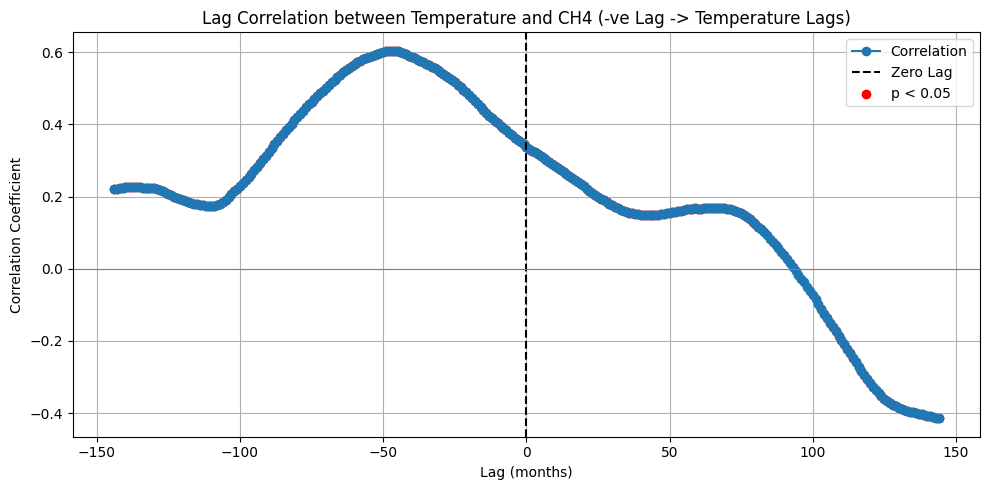

In [38]:
temp_smooth = temp.rolling(window=48, center=True).mean()
ch4_smooth = ch4.rolling(window=48, center=True).mean()

temp_std = (temp_smooth - temp_smooth.mean()) / temp_smooth.std()
ch4_std = (ch4_smooth - ch4_smooth.mean()) / ch4_smooth.std()

max_lag = 144  # in months
lags = range(-max_lag, max_lag + 1)

r_values = []
p_values = []

for lag in lags:
    # align data after shifting
    x = temp_smooth
    y = ch4_smooth.shift(lag)
    valid = ~(x.isna() | y.isna())
    
    if valid.sum() > 2:  # at least 3 points to correlate
        r, p = pearsonr(x[valid], y[valid])
    else:
        r, p = np.nan, np.nan
    r_values.append(r)
    p_values.append(p)

corr_df = pd.DataFrame({'Lag (months)': lags, 'Correlation': r_values, 'p-value': p_values})

# Find the lag with maximum absolute correlation
best_lag = corr_df.loc[corr_df['Correlation'].idxmax()]
print(f"Peak correlation at lag = {best_lag['Lag (months)']} months (r = {best_lag['Correlation']:.3f}, p = {best_lag['p-value']:.4e})")

# --- Plot correlation vs lag ---
plt.figure(figsize=(10,5))
plt.plot(corr_df['Lag (months)'], corr_df['Correlation'], marker='o', label='Correlation')
plt.axvline(0, color='k', linestyle='--', label='Zero Lag')
plt.axhline(0, color='grey', linewidth=0.8)
plt.title('Lag Correlation between Temperature and CH4 (-ve Lag -> Temperature Lags)')
plt.xlabel('Lag (months)')
plt.ylabel('Correlation Coefficient')

# highlight statistically significant lags
sig_mask = corr_df['p-value'] < 0.05
plt.scatter(corr_df.loc[sig_mask, 'Lag (months)'],
            corr_df.loc[sig_mask, 'Correlation'],
            color='red', label='p < 0.05')

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [39]:
import numpy as np
from pyinform.transferentropy import transfer_entropy

# Assuming your data arrays are already detrended
# Normalize to integers (TE works on discrete signals)
def discretize(x, bins=10):
    return np.digitize((x - np.min(x)) / (np.max(x) - np.min(x)), bins=np.linspace(0, 1, bins))

temp_d = discretize(Anomaly_detrended)
co2_d = discretize(CO2_detrended)

# Compute transfer entropy both ways
te_temp_to_co2 = transfer_entropy(temp_d, co2_d, k=1)
te_co2_to_temp = transfer_entropy(co2_d, temp_d, k=1)

print(f"Transfer Entropy (Temperature → CO₂): {te_temp_to_co2:.4f}")
print(f"Transfer Entropy (CO₂ → Temperature): {te_co2_to_temp:.4f}")


Transfer Entropy (Temperature → CO₂): 0.8498
Transfer Entropy (CO₂ → Temperature): 0.6058


In [40]:
import numpy as np
from pyinform.transferentropy import transfer_entropy

# Assuming your data arrays are already detrended
# Normalize to integers (TE works on discrete signals)
def discretize(x, bins=10):
    return np.digitize((x - np.min(x)) / (np.max(x) - np.min(x)), bins=np.linspace(0, 1, bins))

temp_d = discretize(Anomaly_detrended)
cH4_d = discretize(CH4_detrended)

# Compute transfer entropy both ways
te_temp_to_cH4 = transfer_entropy(temp_d, cH4_d, k=1)
te_cH4_to_temp = transfer_entropy(cH4_d, temp_d, k=1)

print(f"Transfer Entropy (Temperature → CH4): {te_temp_to_cH4:.4f}")
print(f"Transfer Entropy (CH4 → Temperature): {te_cH4_to_temp:.4f}")

Transfer Entropy (Temperature → CH4): 0.4342
Transfer Entropy (CH4 → Temperature): 0.3457


## Checking correlation between methane emissions and temperature

In [41]:
temp_data = pd.read_csv("Temp_Data.csv")
methane_data = pd.read_csv("Methane_Emissions.csv")

In [42]:
# Convert time column to datetime
temp_data['Time'] = pd.to_datetime(temp_data['Time'])
temp_data['year'] = temp_data['Time'].dt.year


In [43]:
annual_anomaly = temp_data.groupby('year')['Anomaly'].mean().reset_index()
merged_df = pd.merge(annual_anomaly, methane_data, on='year', how='inner')


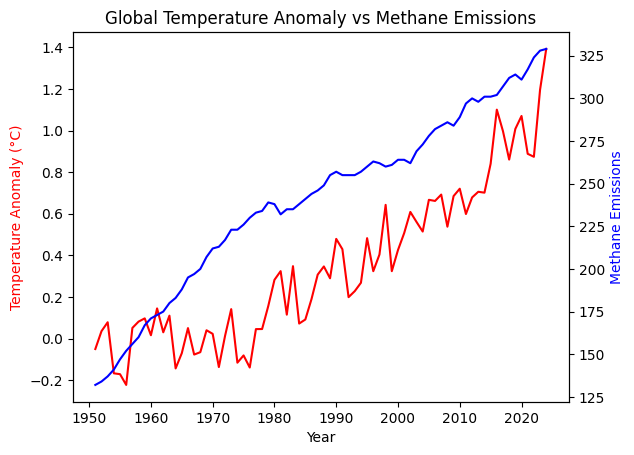

In [44]:
fig, ax1 = plt.subplots()

# Plot temperature anomaly
ax1.plot(merged_df['year'], merged_df['Anomaly'], color='red', label='Temperature Anomaly (°C)')
ax1.set_xlabel('Year')
ax1.set_ylabel('Temperature Anomaly (°C)', color='red')

# Plot methane on secondary axis
ax2 = ax1.twinx()
ax2.plot(merged_df['year'], merged_df['mt'], color='blue', label='Methane Emissions')
ax2.set_ylabel('Methane Emissions', color='blue')

plt.title('Global Temperature Anomaly vs Methane Emissions')
plt.show()

Peak correlation at lag = 17.0 months (r = 0.393, p = 2.5063e-03)


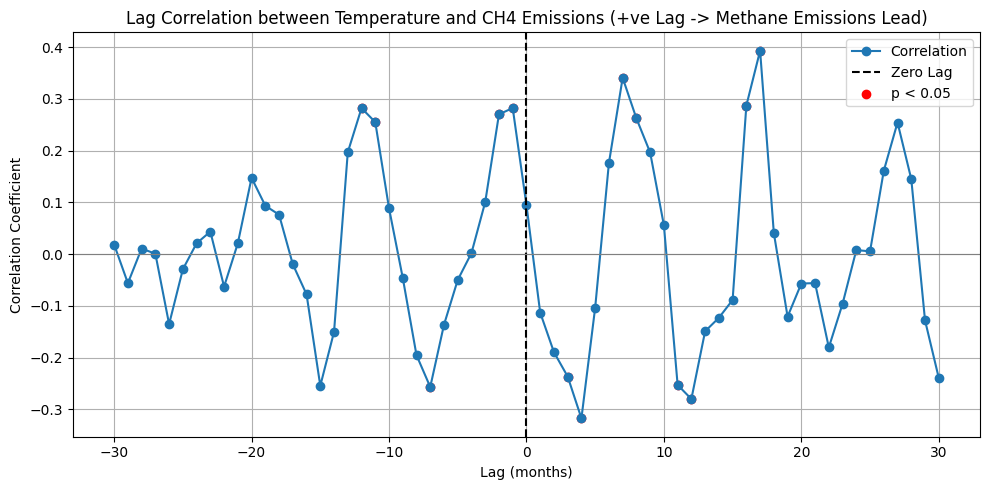

In [45]:
# Suppose merged_df has 'year', 'anomaly', 'Methane_Emissions'
methane = merged_df['mt']
temp = merged_df['Anomaly']

# Detrend if necessary (optional but recommended)
methane_detrended = methane - methane.rolling(window=10, center=True, min_periods=1).mean()
temp_detrended = temp - temp.rolling(window=10, center=True, min_periods=1).mean()

# Define lags (e.g., from -20 to +20 years)
max_lag = 30  # in months
lags = range(-max_lag, max_lag + 1)

r_values = []
p_values = []

for lag in lags:
    # align data after shifting
    x = methane_detrended
    y = temp_detrended.shift(lag)
    valid = ~(x.isna() | y.isna())
    
    if valid.sum() > 2:  # at least 3 points to correlate
        r, p = pearsonr(x[valid], y[valid])
    else:
        r, p = np.nan, np.nan
    r_values.append(r)
    p_values.append(p)

corr_df = pd.DataFrame({'Lag (months)': lags, 'Correlation': r_values, 'p-value': p_values})

# Find the lag with maximum absolute correlation
best_lag = corr_df.loc[corr_df['Correlation'].abs().idxmax()]
print(f"Peak correlation at lag = {best_lag['Lag (months)']} months (r = {best_lag['Correlation']:.3f}, p = {best_lag['p-value']:.4e})")

# --- Plot correlation vs lag ---
plt.figure(figsize=(10,5))
plt.plot(corr_df['Lag (months)'], corr_df['Correlation'], marker='o', label='Correlation')
plt.axvline(0, color='k', linestyle='--', label='Zero Lag')
plt.axhline(0, color='grey', linewidth=0.8)
plt.title('Lag Correlation between Temperature and CH4 Emissions (+ve Lag -> Methane Emissions Lead)')
plt.xlabel('Lag (months)')
plt.ylabel('Correlation Coefficient')

# highlight statistically significant lags
sig_mask = corr_df['p-value'] < 0.05
plt.scatter(corr_df.loc[sig_mask, 'Lag (months)'],
            corr_df.loc[sig_mask, 'Correlation'],
            color='red', label='p < 0.05')

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



In [46]:

import pyinform.transferentropy as te
import numpy as np

# Prepare discrete time series (TE requires discrete bins)
methane_series = np.digitize(methane, np.histogram(methane, bins=10)[1]) - 1
temp_series = np.digitize(temp, np.histogram(temp, bins=10)[1]) - 1

# Compute transfer entropy: Methane → Temperature
te_methane_to_temp = te.transfer_entropy(methane_series, temp_series, k=1)

# Compute reverse: Temperature → Methane
te_temp_to_methane = te.transfer_entropy(temp_series, methane_series, k=1)

print("Transfer Entropy (Methane → Temp):", te_methane_to_temp)
print("Transfer Entropy (Temp → Methane):", te_temp_to_methane)


Transfer Entropy (Methane → Temp): 0.6384594482692192
Transfer Entropy (Temp → Methane): 0.20624450076430245


In [47]:
merged_df.to_csv('Methane_Temp.csv', index = False)

In [54]:
co2 = pd.read_csv('co2_mm_mlo.csv')
annual_co2 = co2.groupby('year')['average'].mean().reset_index()

In [55]:
annual_co2.to_csv('Annual_CO2.csv', index = False)

In [ ]:
# Meth_CO2_Temp = pd.read_csv('Methane_CO2_Temp.csv')

In [ ]:
# fig, ax1 = plt.subplots()

# # Plot temperature anomaly
# ax1.plot(Meth_CO2_Temp['year'], Meth_CO2_Temp['anomaly'], color='red', label='Temperature Anomaly (°C)')
# ax1.set_xlabel('Year')
# ax1.set_ylabel('Temperature Anomaly (°C)', color='red')

# # Plot methane on secondary axis
# ax2 = ax1.twinx()
# ax2.plot(Meth_CO2_Temp['year'], Meth_CO2_Temp['mt'], color='blue', label='Methane Emissions')
# ax2.set_ylabel('Methane Emissions', color='blue')

# ax3 = ax1.twinx()
# ax3.spines["right"].set_position(("outward", 60))
# ax3.plot(Meth_CO2_Temp['year'], Meth_CO2_Temp['co2'], color='green', label='CO2 conc.')
# ax3.set_ylabel('CO2 concentration', color='green')


# plt.title('Global Temperature Anomaly vs CO2 conc. and Methane Emissions')
# plt.show()

In [ ]:
# # Suppose merged_df has 'year', 'anomaly', 'Methane_Emissions'
# methane = Meth_CO2_Temp['mt']
# temp = Meth_CO2_Temp['anomaly']

# # Detrend if necessary (optional but recommended)
# methane_detrended = methane - methane.rolling(window=5, center=True, min_periods=1).mean()
# temp_detrended = temp - temp.rolling(window=5, center=True, min_periods=1).mean()

# # Define lags (e.g., from -20 to +20 years)
# max_lag = 20
# lags = range(-max_lag, max_lag + 1)
# corrs = [methane_detrended.corr(temp_detrended.shift(lag)) for lag in lags]

# # Plot
# plt.figure(figsize=(8,5))
# plt.plot(lags, corrs, marker='o')
# plt.axvline(0, color='k', linestyle='--', label='Zero lag')
# plt.xlabel('Lag (years)')
# plt.ylabel('Correlation coefficient')
# plt.title('Lag correlation between Methane and Temperature')
# plt.legend()
# plt.show()

In [ ]:
# carbon_di = Meth_CO2_Temp['co2']
# temp = Meth_CO2_Temp['anomaly']

# # Detrend if necessary (optional but recommended)
# carbon_di_detrended = carbon_di - carbon_di.rolling(window=5, center=True, min_periods=1).mean()
# temp_detrended = temp - temp.rolling(window=5, center=True, min_periods=1).mean()

# # Define lags (e.g., from -20 to +20 years)
# max_lag = 50
# lags = range(-max_lag, max_lag + 1)
# corrs = [temp_detrended.corr(carbon_di_detrended.shift(lag)) for lag in lags]

# # Plot
# plt.figure(figsize=(8,5))
# plt.plot(lags, corrs, marker='o')
# plt.axvline(0, color='k', linestyle='--', label='Zero lag')
# plt.xlabel('Lag (years)')
# plt.ylabel('Correlation coefficient')
# plt.title('Lag correlation between CO2 and Temperature')
# plt.legend()
# plt.show()